In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d  
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
import random
from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# from EDA_helper import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import torch.nn.functional as F

!pip install coral_pytorch
import coral_pytorch as coral
from coral_pytorch.layers import CoralLayer
from coral_pytorch.dataset import levels_from_labelbatch
from coral_pytorch.losses import coral_loss
from coral_pytorch.dataset import proba_to_label


In [2]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [3]:
#@title
def format_df(figs, ratings, to_drop = []):
    """
    figs: Pandas df, features
    ratings: Pandas df, labels
    to_drop: list, cols to remove

    """

#     print(len(ratings["Ticker Symbol"].unique()))
    ratings1 = ratings[ratings['S&P Domestic Long Term Issuer Credit Rating'].notna()]
    ratings1 = ratings1[['Global Company Key','S&P Domestic Long Term Issuer Credit Rating', 'Data Date',
                        'Ticker Symbol']]

    print("Unique Companies in Ratings: ", len(ratings1["Ticker Symbol"].unique()))
    # print("Unique Companies in Features: ", len(figs["Ticker Symbol"].unique()))

    ## WE DON'T USE THIS
    if len(to_drop) == 0:
        figs_1 = figs.drop(list(figs.columns[[2, 3,4,11,12, 14, 16, 18, 20, 21, 23, 26, 30, 33, 35, 36, 37, 38]]), axis=1).dropna()
    else:
        # print(ratings1.shape, figs.shape)
        figs_1 = figs.drop(to_drop, axis=1).dropna()
        # print(ratings1.shape, figs_1.shape)
    print("Unique Companies in Features: ", len(figs_1["Ticker Symbol"].unique()))

    # lst3 = [value for value in ratings1["Ticker Symbol"].unique() if value in figs_1["Ticker Symbol"].unique()]


    companies = ratings1["Ticker Symbol"].unique()
    # companies
    # quarts = ['1231', '0331', '0630', '0930']
    # figs_1 = figs_1.loc[figs_1['Ticker Symbol'].isin(companies)]
    print("changed")
    figs_1['Data Date'] = figs_1['Data Date'].astype(str)
    ratings1['Data Date'] = ratings1['Data Date'].astype(str)
    # ratings1 = ratings1.loc[ratings1['Data Date'].str[-4:].isin(quarts)]
    return figs_1, ratings1


def join_numerical(figs_1, ratings1, numerical=[], ind_to_keep=[], years=[]):
    """
    in
    figs_1: Pandas df, features
    ratings1: Pandas df, labels
    numerical: List of str col. names of numerical columns to keep

    out
    x: np array
    y: np array
    merged: Pandas df
    """
    merged = pd.merge(figs_1, ratings1, how='inner', on=["Data Date", "Ticker Symbol"])
    merged = merged.rename(columns = {'S&P Domestic Long Term Issuer Credit Rating':'rating'})

    if len(numerical) == 0:
        numerical = ['Current Assets - Total', 'Cash','Long-Term Debt - Total',
        'Earnings Per Share (Basic) - Including Extraordinary Items - 12 Months Moving',
        'Invested Capital - Total - Quarterly','Inventories - Total', 'Pretax Income',
        'Operating Income Before Depreciation']
    vals = merged['Data Date'].str[:4]
    merged['year'] = vals
    # yrs =



    merged = merged[(merged['rating'] != 'D') & (merged['rating'] != 'SD')]

    counts =  merged['rating'].value_counts()
    good_classes = [counts.index[j] for j in range(len(counts)) if counts[j] >=7]
    merged = merged[merged['rating'].isin(good_classes)]
    if len(years) != 0:
        merged = merged[merged['year'].isin(years)]
    # merged = merged.drop(['year'], axis=1)
    if len(ind_to_keep) == 0:
        ind_to_keep = [True]*len(merged)

    x = merged.loc[ind_to_keep, numerical].values
    y = merged.loc[ind_to_keep,['rating']].values
    full = numerical.copy()
    full.append('rating')
    full.append('year')
    full.append('Ticker Symbol')



    merged = merged.loc[ind_to_keep, full]


    print("Intersection of Companies: ", len(merged['Ticker Symbol'].unique()))
    return x, y, merged

def encode(Y, form='', custom={}):

    if custom:
        pass

    else:
        if form == 'full':
            embed = {'BBB-':-1, 'BBB':0, 'A-':2, 'BBB+':1, 'AA+':7, 'AA':6, 'A':3, 'AA-':5, 'BB':-3, 'BB+':-2,
                                'AAA':8, 'B':-6, 'B+':-5, 'A+':4, 'BB-':-4, 'CCC+':-8,'CCC':-9,'CCC-':-10, 'CC+':-11,'CC':-12,
                                'CC-':-13,'B-':-7}
            labels = ['CCC','CCC+','B-', 'B', 'B+', 'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+',
                   'AA-', 'AA', 'AA+', 'AAA']
        elif form == 'stanfurd':
            embed = {'BBB-':-1, 'BBB':0, 'A-':2, 'BBB+':1, 'AA+':7, 'AA':6, 'A':3, 'AA-':5, 'BB':-3, 'BB+':-2,
                                'AAA':7, 'B':-6, 'B+':-5, 'A+':4, 'BB-':-4, 'CCC+':-8, 'B-':-7}
            labels = ['CCC+','B-', 'B', 'B+', 'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+',
                   'AA-', 'AA', 'AA+', 'AAA']
        elif form == 'three':
            embed = {'BBB-':1, 'BBB':1, 'A-':2, 'BBB+':1, 'AA+':2, 'AA':2, 'A':2, 'AA-':2, 'BB':0, 'BB+':0,
                    'AAA':2, 'B':0, 'B+':0, 'A+':2, 'BB-':0, 'CCC+':0, 'B-':0}
            labels = ['low', 'med', 'high']
        elif form == "IG":
            embed = {'BBB-':1, 'BBB':1, 'A-':1, 'BBB+':1, 'AA+':1, 'AA':1, 'A':1, 'AA-':1, 'BB':0, 'BB+':0,
                    'AAA':1, 'B':0, 'B+':0, 'A+':1, 'BB-':0, 'CCC+':0, 'B-':0}
            labels = ['HY', 'IG']

        elif form == 'letters':
            embed = {'BBB-':3, 'BBB':3, 'A-':4, 'BBB+':3, 'AA+':5, 'AA':5, 'A':4, 'AA-':5, 'BB':2, 'BB+':2,
                    'AAA':6, 'B':1, 'B+':1, 'A+':4, 'BB-':2, 'CCC+':0, 'B-':1}
            labels = ['CCC', 'B', 'BB', 'BBB', 'A', 'AA','AAA']
        # elif form == 'letters ex CCC':
        else:
            embed = {'BBB-':4, 'BBB':4, 'A-':5, 'BBB+':4, 'AA+':6, 'AA':6, 'A':5, 'AA-':6, 'BB':3, 'BB+':3,
                  'AAA':7, 'B':2, 'B+':2, 'A+':5, 'BB-':3, 'CCC+':1, 'B-':2, 'CCC':1,'CCC-':1, 'CC+':0,'CC':0,
                    'CC-':0}
            labels = ['B', 'BB', 'BBB', 'A', 'AA','AAA']
            # colors = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139', '#828282', '#17d8ff', '#1770ff']
        Y_emb = np.array([embed[i] for i in Y.T[0]]).ravel()

    return Y_emb, labels

def decode(Y, form='', custom={}):
    if form == 'full':
            embed = {-1:'BBB-', 0:'BBB', 2:'A-', 1:'BBB+', 7:'AA+', 6:'AA', 3:'A', 5:'AA-', -3:'BB', -2:'BB+',
                            8:'AAA', -6:'B', -5:'B+', 4:'A+', -4:'BB-', -8:'CCC+',-9:'CCC',-10:'CCC-', -11:'CC+',
                     -12:'CC', -13:'CC-',-7:'B-'}
            labels = ['CC','CC+','CCC', 'CCC+','B-', 'B', 'B+', 'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+',
                   'AA-', 'AA', 'AA+', 'AAA']
    Y_emb = np.array([embed[i] for i in Y.T[0]]).ravel()
    return Y_emb, labels
def data_split(X, Y,full=None, split=[0.7, 0.1], method="numer", smote=False, seed=100, neigh=5):
    """
    split = [ratio of train, ratio of val]
    note: ratio of test = 1.0 - (ratio of train + ratio of val)
    """
    np.random.seed(seed)

    #### TODO: if smote, give a non-smote Validation set
    ## No Validation set
    if split[1] == 0.0:
        test_split = 1.0 - split[0]

        if method == 'numer':
            splits = int(np.round(split[0]*X.shape[0]))
            cc = list(np.arange(X.shape[0])).copy()
            np.random.shuffle(cc)
            train_inds = cc[:splits]
            test_inds = cc[splits:]
            X_train = X[train_inds, :]
            Y_train = Y[train_inds]
            X_test =  X[test_inds, :]
            Y_test =  Y[test_inds]

            X_val = []
            Y_val = []

        # elif method == "holdout":
            # X is DataFrame
            # Y is empty
        if smote:
            # ks = np.min([np.min(), 5])
            dd = {}
            uu = {}
            kounts = pd.Series(enc_Y).value_counts().to_dict()
            max_val = max(kounts.values())
            for k,v in kounts.items():
              dd[k] = int((max_val - v)*0.2 + v)
            for c,d in sorted(kounts.items(), key=lambda item: item[1])[-5:]:
              uu[c] = int(d*0.7)

            oversample = SMOTE(sampling_strategy=dd, k_neighbors=neigh)
            undersample =RandomUnderSampler(sampling_strategy=uu)
            steps = [('o', oversample), ('u', undersample)]
            pipeline = Pipeline(steps=steps)
            # print("SVMMMM")

            X_train, Y_train = pipeline.fit_resample(X_train, Y_train)


    else:
        if method == 'numer':
            splits = int(np.round(split[0]*X.shape[0]))
            splits1 = splits + int(np.round(split[1]*X.shape[0]))
            cc = list(np.arange(X.shape[0])).copy()
            np.random.shuffle(cc)
            train_inds = cc[:splits]
            val_inds = cc[splits:splits1]
            test_inds = cc[splits1:]

            X_train = X[train_inds, :]
            Y_train = Y[train_inds]
            X_val = X[val_inds, :]
            Y_val = Y[val_inds]

            X_test =  X[test_inds, :]
            Y_test =  Y[test_inds]

        if smote:
            # ks = np.min([np.min(), 5])
            oversample = SMOTE(k_neighbors=neigh)
            X_train, Y_train = oversample.fit_resample(X_train, Y_train)



    return X_train, Y_train, X_val, Y_val, X_test, Y_test


In [4]:
# ratings = pd.read_excel("drive/My Drive/Honors Thesis/datasets/ratings_all_energ_new.xlsx")
ratings = pd.read_excel("../datasets/ratings_all_energ_new.xlsx")
# ratio = pd.read_excel("drive/My Drive/Honors Thesis/datasets/ratios_2_all_energ_new.xlsx")
ratio = pd.read_excel("../datasets/ratios_2_all_energ_new.xlsx")
# energ = pd.read_excel("drive/My Drive/Honors Thesis/datasets/energ_specific_all_new.xlsx")
energ = pd.read_excel("../datasets/energ_specific_all_new.xlsx")
# # ratings = pd.read_excel("../datasets/ratings_2_06-17.xlsx")
# # ratio = pd.read_excel("../datasets/ratio_figs_2.xlsx")
cols = ratio.columns
ratio = ratio.drop(cols[0], axis=1)
ratio = ratio.rename(columns = {'Public Date':'Data Date','EXCHANGE TICKER SYMBOL - HISTORICAL':'Ticker Symbol'})

ratio1, ratings1 = format_df(ratio.copy(), ratings.copy(), 
                             ['Trailing P/E to Growth (PEG) ratio','Dividend Yield', 
                              'Interest/Average Total Debt', 'Free Cash Flow/Operating Cash Flow'])

numer = list(ratio1.columns[4:-1])

Unique Companies in Ratings:  335
Unique Companies in Features:  253
changed


In [5]:
cols = energ.columns
# aa = cols[[0,1,2,3,4,5,6, 18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]]
aa = cols[[0,1,2,3,4,5,6, 10,11,14,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]]
energ1 = energ.drop(
       aa, 
    axis=1)
# energ1 = energ_.fillna(energ_.mean()) 
# energ1, _ = format_df(energ.copy(), ratings.copy(), 
#                             aa)
energ1['Data Date'] = energ1['Data Date'].astype(str)

In [6]:
features = pd.merge(ratio1, energ1,how='left',on=["Data Date", "Ticker Symbol"])
len(features["Ticker Symbol"].unique())
lst3 = [value for value in ratio["Ticker Symbol"].unique() if value in energ["Ticker Symbol"].unique()]
# ratio1["Ticker Symbol"].unique()
len(lst3)
print(len(ratio["Ticker Symbol"].unique()), len(energ["Ticker Symbol"].unique()), 
      len(ratio1["Ticker Symbol"].unique()), len(energ1["Ticker Symbol"].unique()))

first_col = features.pop("Ticker Symbol") 
ff = len(features.columns)
features.insert(ff, "Ticker Symbol", first_col)

273 819 253 819


In [7]:
def ordinal_one_hot(Y_train, Y_test):
    max_y = np.max([Y_train.max(), Y_test.max()])
    shape1 = (Y_train.size, max_y+1)
    shape2 = (Y_test.size, max_y+1)
    print(shape1)
    hot_train = np.zeros(shape1)
    hot_test = np.zeros(shape2)
    for j in range(Y_train.size):
        hot_train[j, :Y_train[j]] = 1
    for k in range(Y_test.size):
        hot_test[k, :Y_test[k]] = 1
    assert (np.sum(hot_train, axis=1) == Y_train).all()
    assert (np.sum(hot_test, axis=1) == Y_test).all()
    return hot_train, hot_test


In [8]:
# classes: [0, 17] i.e. 18 classes
def coral_one_hot(Y_train, Y_test):
    max_y = np.max([Y_train.max(), Y_test.max()])
    # indices [0, 16]
    shape1 = (Y_train.size, max_y)
    shape2 = (Y_test.size, max_y)
    print(shape1)
    hot_train = np.zeros(shape1)
    hot_test = np.zeros(shape2)

    # hot_train = np.where(hot_train > )
    for j in range(Y_train.size):
        hot_train[j, :Y_train[j]] = 1
    for k in range(Y_test.size):
        hot_test[k, :Y_test[k]] = 1
    assert (np.sum(hot_train, axis=1) == Y_train).all()
    assert (np.sum(hot_test, axis=1) == Y_test).all()
    return hot_train, hot_test

In [15]:
tick = 'XOM'
full1[full1['Ticker Symbol'] == tick].fillna(0)


,Enterprise Value Multiple,"P/E (Diluted, Excl. EI)",Price/Cash flow,Net Profit Margin,Operating Profit Margin Before Depreciation,Cash Flow Margin,Total Debt/Invested Capital,Cash Balance/Total Liabilities,Total Debt/EBITDA,Profit Before Depreciation/Current Liabilities,...,Average Sales Price - NG,Average Sales Price - Oil,Production - NGL (Total),Production - NG (Total),Production - Oil (Total),Dry Hole Expense,Exploration Expense,rating,year,Ticker Symbol
86,6.757003,11.839623,7.688304,0.107858,0.177284,0.140353,0.076917,0.302989,0.153536,1.181925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AAA,2006,XOM
87,6.008077,10.397548,7.531119,0.110081,0.180538,0.141320,0.066078,0.355419,0.134858,1.279612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AAA,2006,XOM
88,6.008077,10.658494,7.720126,0.110081,0.180538,0.141320,0.066078,0.355419,0.134858,1.279612,...,0.0,0.0,0.0,0.0,0.0,0.0,282.0,AAA,2006,XOM
89,6.008077,11.047285,7.981890,0.110081,0.180538,0.141320,0.066078,0.355419,0.134858,1.279612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AAA,2006,XOM
90,6.077532,10.394198,7.399957,0.109584,0.185313,0.140496,0.072207,0.338001,0.135170,1.270424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AAA,2006,XOM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,15.318872,34.634921,15.814709,0.051265,0.121513,0.143908,0.198771,0.026321,1.608418,0.477607,...,0.0,0.0,0.0,0.0,0.0,0.0,327.0,AA+,2016,XOM
215,15.318872,33.063492,15.098450,0.051265,0.121513,0.143908,0.198771,0.026321,1.608418,0.477607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AA+,2016,XOM
216,17.880203,40.794393,18.987009,0.045412,0.113184,0.142874,0.211016,0.027601,1.934532,0.436416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AA+,2016,XOM
217,17.880203,42.177570,19.630784,0.045412,0.113184,0.142874,0.211016,0.027601,1.934532,0.436416,...,0.0,0.0,0.0,0.0,0.0,0.0,340.0,AA+,2016,XOM


In [16]:
numer = list(features.columns[4:-1])

X1,Y1,full1 = join_numerical(features, ratings1, numerical=numer)

X1, X_hold_,Y1, Y_hold = train_test_split(X1, Y1, test_size=0.2, random_state=100)

ss = StandardScaler()
scl_X = ss.fit_transform(X1)
scl_X = np.nan_to_num(scl_X)
enc_Y, _ = encode(Y1, 'full') 

n_classes = len(np.unique(enc_Y))
n_feats = scl_X.shape[1]

X_hold = ss.transform(X_hold_)
X_hold = np.nan_to_num(X_hold)

Y_hold, _ = encode(Y_hold, 'full')
minny = np.min((np.min(enc_Y), np.min(Y_hold)))

enc_Y += np.abs(minny)
Y_hold += np.abs(minny)


# pd.Series(Y1.T[0]).value_counts()
# np.min(enc_Y)

Intersection of Companies:  97


In [17]:
X_train, Y_train, _, _,X_test, Y_test = data_split(scl_X, enc_Y, split=[0.8, 0.0], smote=False, seed = 100, neigh=4)

In [18]:
## Preds will be in one hot format, make decision func to convert back to holdout int format
# Y_train_, Y_test_ = coral_one_hot(Y_train, Y_test)
Y_train_, Y_test_ = Y_train, Y_test
Xt_train = torch.FloatTensor(X_train)
Yt_train = torch.Tensor(Y_train_)
Xt_val = torch.FloatTensor(X_test)
Yt_val = torch.Tensor(Y_test_)

Xt_test = torch.FloatTensor(X_hold)
Yt_test = torch.Tensor(Y_hold)

train_set = TensorDataset(Xt_train, Yt_train)
loader_train = DataLoader(train_set, batch_size=10)

val_set = TensorDataset(Xt_val, Yt_val)
loader_val = DataLoader(val_set, batch_size=10)

test_set = TensorDataset(Xt_test, Yt_test)
loader_test = DataLoader(test_set, batch_size=10)

pd.Series(Y_train_).value_counts()

3     759
9     720
6     610
7     498
4     457
8     411
5     353
10    341
12    313
11    234
2     175
15     83
17     82
1      22
13     17
0      14
16      6
14      5
dtype: int64

In [19]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [20]:
# uses ordinal-hot labels

def OrdinalEntropyLoss(outputs, labels):
    batch_size = outputs.size()[0]            
    outputs = torch.sigmoid(outputs)
    outputs = torch.sum((labels*torch.log(outputs) + (1 - labels)*torch.log(1 - outputs)))
    # outputs = F.log_softmax(outputs, dim=1)   
    # outputs = outputs[range(batch_size), labels] 
    return outputs

In [ ]:
def decision_func(scores, t):
  """
  scores: Tensor - Minibatch x num_classes (10 x 18)
  t: threshold
  """
  torch.where(scores > t, 1, 0)


In [21]:
class Coral_bias(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.in_size, self.out_size = in_size, out_size
        # weights = torch.Tensor(out_size, in_size)
        # self.weights = nn.Parameter(weights)  
        bias = torch.Tensor(out_size)
        self.bias = nn.Parameter(bias)

    
        # nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) # weight init
        # fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        # bound = 1 / math.sqrt(fan_in)
        # nn.init.uniform_(self.bias, -bound, bound)  # bias init
        nn.init.kaiming_uniform_(self.bias, a=math.sqrt(5))

    def forward(self, x):
        # w_times_x= torch.mm(x, self.weights.t())
        return x + self.bias  # w times x + b

In [22]:
def plotGD(losses, model):
  plt.plot(losses)
  plt.ylabel('Loss')
  plt.xlabel('Iterations (in 100s)')
  plt.title(model + " Gradient Descent (ADAM)")
def plotAcc(vals, model):
  plt.plot(vals)
  plt.ylabel('Accuracy')
  plt.xlabel('Iterations (in 100s)')
  plt.title(model +  " Gradient Descent (ADAM)")

In [ ]:
## TODO: figure out how many columns ordinal one hot np array has
## one-off errors in below

bnc = torch.Tensor([[0.6,0.2, 0.4],
                [0.6,0.6, 0.6]])
cnc = bnc.numpy()
cnc = np.hstack((cnc, np.zeros((cnc.shape[0],1))))

temp_arg = np.argmax(cnc<= 0.5, axis=1)
# np.where(temp_arg >= 0, temp_arg, 0)
# cnc = cnc[:, :-1]
# cnc
# ac = torch.FloatTensor(cnc)
# np.argmax(ac.to_num > 0.5, dim=1)
# ac > 0.5
# cnc.shape
temp_arg

array([1, 3])

In [23]:

def check_accuracy_part34(loader, model, normal =False):
    # if loader.dataset.train:
    #     print('Checking accuracy on validation set')
    # else:
    #     print('Checking accuracy on test\ set')   
    num_correct = 0
    num_samples = 0
    mae = 0.
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
 
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.float().to(device=device)

            if normal:
              scores = model(x)
              _, preds = scores.max(1)
            else:
  
              scores, probs = model(x)
            # print("scores: ",scores.size())
              preds = proba_to_label(probs).float()


            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            mae += torch.sum(torch.abs(preds - y))
            # mse += torch.sum((preds - y)**2)
        acc = float(num_correct) / num_samples
        mae = mae / num_samples
        # mse = mse / num_examples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc), f'Mean absolute error: {mae:.2f}')
    return acc, mae

In [24]:
def train_part34(model, optimizer, epochs=1, normal=False):
    """
    Train a model on CIFAR-10 using the PyTorch Module API and prints model 
    accuracies during training.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Lists of validation accuracies at the end of each epoch.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    train_accs = []
    val_accs = []
    val_mae = []
    losses = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            # print(y)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU

            if normal:
              y = y.to(device=device, dtype=torch.long)
              scores = model(x)
              loss = F.cross_entropy(scores, y)
              

            else:
              levels = levels_from_labelbatch(y.int(), num_classes=num_classes)
              levels = levels.to(device=device, dtype=torch.long)
              scores, probs = model(x)
              loss = coral_loss(scores, levels)
            
         

            # print(scores)
            # print(scores.size(), y.size())
            
            
            # loss = F.nll_loss(scores, y, reduction='sum')
            # loss = OrdinalEntropyLoss(scores, y)

            # print(loss.size())

    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                losses.append(loss.item())
                check_accuracy_part34(loader_val, model, normal)
                print()
        acc_, mae_ = check_accuracy_part34(loader_val, model, normal)
        val_accs.append(acc_)
        val_mae.append(mae_)
        
    return val_accs, val_mae, losses

In [ ]:
class CoralNet(nn.Module):
  def __init__(self, num_classes, num_features,                              
                                    hidden_layer_size = 100 ):
    super().__init__()

    self.features = torch.nn.Sequential(
        nn.Linear(num_features, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        # nn.Linear(hidden_layer_size, hidden_layer_size),
        # nn.ReLU(),
        # nn.Linear(hidden_layer_size, hidden_layer_size),
        # nn.ReLU()
        )
    # self.features = torch.nn.Sequential(
    # nn.Linear(num_features, hidden_layer_size),
    # nn.Sigmoid(),
    # nn.Linear(hidden_layer_size, hidden_layer_size),
    # nn.Sigmoid(),
    # nn.Linear(hidden_layer_size, hidden_layer_size),
    # nn.Sigmoid(),      
    # nn.Linear(hidden_layer_size, hidden_layer_size),
    # nn.Sigmoid(),      
    # nn.Linear(hidden_layer_size, hidden_layer_size),
    # nn.Sigmoid(),
    # nn.Linear(hidden_layer_size, hidden_layer_size),
    # nn.Sigmoid(),
    # )
    self.fc = CoralLayer(hidden_layer_size, num_classes)

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    logits =  self.fc(x)
    probas = torch.sigmoid(logits)

    return logits, probas


In [25]:
class NormalNet(nn.Module):
  def __init__(self, num_classes, num_features,                              
                                    hidden_layer_size = 100 ):
    super().__init__()

    self.features = torch.nn.Sequential(
        nn.Linear(num_features, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU()
        )
    self.fc = nn.Linear(hidden_layer_size, num_classes)

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    logits =  self.fc(x)


    return logits



In [26]:
num_features = n_feats
learning_rate = 7e-4
hidden_layer_size = 250 
epics = 100

num_classes = n_classes

### CORAL NN

In [ ]:
model1 = None
optimizer1 = None


# model = nn.Sequential(
#     # Flatten(),
#     nn.Linear(num_features, hidden_layer_size),
#     nn.ReLU(),
#     nn.Linear(hidden_layer_size, hidden_layer_size),
#     nn.ReLU(),
#     # nn.Sigmoid(),
#     # nn.Linear(hidden_layer_size, num_classes, bias=False),

#     # nn.LogSoftmax()

# )


model1 = CoralNet(num_classes, num_features, hidden_layer_size)
normal = False
# model = NormalNet(num_classes, num_features, hidden_layer_size)
# normal = True


optimizer1 = optim.SGD(model1.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)  
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)  

coral_validation_accs, coral_maes, coral_losses = train_part34(model1, optimizer1, epochs=epics, normal=normal)
print("Final Acc: \n")
check_accuracy_part34(loader_val, model1, normal)
# np.save('pytorch_10epochs.npy', validation_accs)

Streaming output truncated to the last 5000 lines.
Iteration 0, loss = 0.4901
Got 1093 / 1275 correct (85.73) Mean absolute error: 0.19

Iteration 100, loss = 0.4593
Got 1094 / 1275 correct (85.80) Mean absolute error: 0.19

Iteration 200, loss = 0.3010
Got 1072 / 1275 correct (84.08) Mean absolute error: 0.21

Iteration 300, loss = 0.3510
Got 1092 / 1275 correct (85.65) Mean absolute error: 0.19

Iteration 400, loss = 0.3739
Got 1098 / 1275 correct (86.12) Mean absolute error: 0.19

Iteration 500, loss = 0.4882
Got 1081 / 1275 correct (84.78) Mean absolute error: 0.20

Got 1080 / 1275 correct (84.71) Mean absolute error: 0.20
Iteration 0, loss = 0.4603
Got 1079 / 1275 correct (84.63) Mean absolute error: 0.20

Iteration 100, loss = 0.4598
Got 1087 / 1275 correct (85.25) Mean absolute error: 0.20

Iteration 200, loss = 0.3081
Got 1061 / 1275 correct (83.22) Mean absolute error: 0.22

Iteration 300, loss = 0.3485
Got 1077 / 1275 correct (84.47) Mean absolute error: 0.21

Iteration 400, 

(0.8564705882352941, tensor(0.2008, device='cuda:0'))

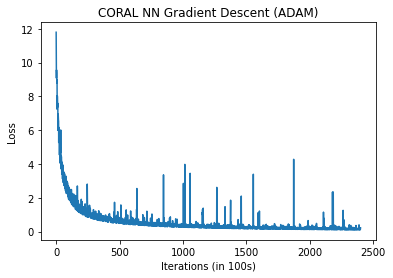

In [ ]:
plotGD(coral_losses, model='CORAL NN')


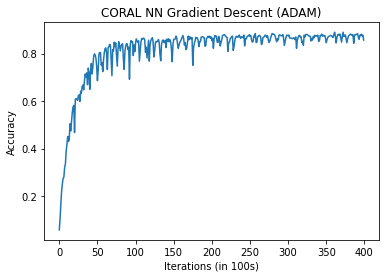

In [ ]:
plotAcc(coral_validation_accs, model='CORAL NN')

Iteration 0, loss = 2.8692
Got 107 / 1275 correct (8.39) Mean absolute error: 2.80

Iteration 100, loss = 2.2227
Got 239 / 1275 correct (18.75) Mean absolute error: 2.71

Iteration 200, loss = 2.0836
Got 364 / 1275 correct (28.55) Mean absolute error: 1.91

Iteration 300, loss = 1.5182
Got 373 / 1275 correct (29.25) Mean absolute error: 1.87

Iteration 400, loss = 1.3431
Got 405 / 1275 correct (31.76) Mean absolute error: 1.73

Iteration 500, loss = 2.3798
Got 432 / 1275 correct (33.88) Mean absolute error: 1.72

Got 438 / 1275 correct (34.35) Mean absolute error: 1.62
Iteration 0, loss = 2.2985
Got 432 / 1275 correct (33.88) Mean absolute error: 1.65

Iteration 100, loss = 2.1061
Got 419 / 1275 correct (32.86) Mean absolute error: 1.69

Iteration 200, loss = 1.1265
Got 485 / 1275 correct (38.04) Mean absolute error: 1.58

Iteration 300, loss = 0.9954
Got 528 / 1275 correct (41.41) Mean absolute error: 1.44

Iteration 400, loss = 0.9713
Got 488 / 1275 correct (38.27) Mean absolute erro

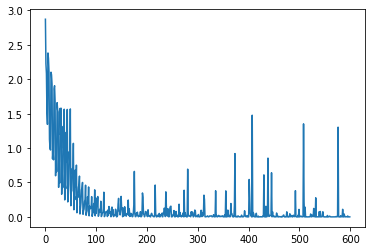

In [ ]:

model = NormalNet(num_classes, num_features, hidden_layer_size)
normal = True
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

validation_accs, maes, losses = train_part34(model, optimizer, epochs=100, normal=normal)
print("Final Acc: \n")
check_accuracy_part34(loader_val, model, normal)
# plt.plot(losses)

Got 1399 / 1594 correct (87.77) Mean absolute error: 0.27
(0.8776662484316186, tensor(0.2679, device='cuda:0'))


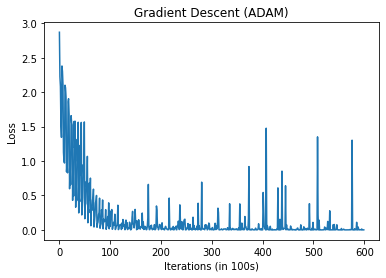

In [ ]:
plotGD(losses, model='Baseline NN')
plotAcc(validation_accs, model='Baseline NN')


In [ ]:
k = 56
x_test = val_set[k][0]
y_test = val_set[k][1]
x_test = x_test.to(device=device, dtype=dtype) 
y_test = y_test.to(device=device, dtype=torch.long)
pred = model(x_test)
# pred.size()
# F.cross_entropy(torch.reshape(pred, (1, num_classes)), 
                # torch.reshape(y_test, (1,)))

torch.sum(nn.Sigmoid()(pred))
# pred

RuntimeError: ignored

In [ ]:
class BASELSTM(nn.Module):
    """."""

    def __init__(self, input_dimensions=4, hidden_dimensions=512, num_classes=2, num_layers=2,
                 dropout=0.0, batch_first=True, bidirectional=False, seq_len=64):
        super(BASELSTM, self).__init__()
        
        self.input_dimensions = input_dimensions
        self.hidden_dimensions = hidden_dimensions

        self.num_classes = num_classes

        self.num_layers = num_layers
        self.dropout = dropout

        self.batch_first = batch_first

        self.bidirectional = bidirectional
        self.seq_len = seq_len

        # GRU Layer
        self.gru = nn.GRU(input_size=self.input_dimensions, hidden_size=self.hidden_dimensions,
                          num_layers=self.num_layers, batch_first=self.batch_first,
                          dropout=self.dropout, bidirectional=self.bidirectional)

In [ ]:
model = nn.Sequential(
    # Flatten(),
#     nn.Linear(num_features, hidden_layer_size),
#     nn.ReLU(),
    nn.LSTM()
    nn.Linear(hidden_layer_size, hidden_layer_size),
    nn.ReLU(),
    # nn.Sigmoid(),
    # nn.Linear(hidden_layer_size, num_classes, bias=False),

    # nn.LogSoftmax()
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

validation_accs, maes, losses = train_part34(model, optimizer, epochs=100, normal=normal)
print("Final Acc: \n")
check_accuracy_part34(loader_val, model, normal)

# New Section

In [ ]:
Got 898 / 1275 correct (70.43)
# 2 hidden
# adam
# lr = 1e-3
# epochs =20


Got 915 / 1275 correct (71.76)
# 2 hidden
# SGD
# lr = 1e-2
# epochs =20


Got 1088 / 1275 correct (85.33)
# adam 
# cross entropy loss (logsoftmax + NLLoss)
# no one hot
# lr = 1e-3
# epochs 100

90% 
adam 
lr: 1e-3
hidden size = 200


Got 1064 / 1275 correct (83.45)
# CORAL
# 1e-3
# 5 hidden
# epochs 100